In [1]:

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Optional (for correlation p-values)
try:
    from scipy.stats import pearsonr, spearmanr
except Exception:
    pearsonr, spearmanr = None, None

# -----------------------------
# Global plotting style (Nature-ish, minimal, readable)
# -----------------------------
plt.rcParams["figure.dpi"] = 160
plt.rcParams["savefig.dpi"] = 300
plt.rcParams["font.size"] = 9
plt.rcParams["axes.titlesize"] = 10
plt.rcParams["axes.labelsize"] = 9
plt.rcParams["legend.fontsize"] = 8
plt.rcParams["axes.spines.top"] = False
plt.rcParams["axes.spines.right"] = False
plt.rcParams["axes.grid"] = True
plt.rcParams["grid.alpha"] = 0.25
plt.rcParams["legend.frameon"] = False

FIG_DIR = os.path.join("..", "results", "figs")
os.makedirs(FIG_DIR, exist_ok=True)

def _first_existing_path(paths):
    for p in paths:
        if p is None:
            continue
        if os.path.exists(p):
            return p
    return None

def load_exp14_summary():
    # Try common locations (repo-style + local upload-style).
    candidates = [
        os.path.join("..", "results", "tables", "exp14_multicity_tabular_summary.csv"),
        os.path.join("..", "results", "tables", "exp14_multicity_tabular_summary_v2.csv"),
        os.path.join("..", "results", "tables", "exp14_multicity_tabular_summary_v3.csv"),
        os.path.join("results", "tables", "exp14_multicity_tabular_summary.csv"),
        os.path.join("results", "tables", "exp14_multicity_tabular_summary_v2.csv"),
        os.path.join("results", "tables", "exp14_multicity_tabular_summary_v3.csv"),
        os.path.join(".", "exp14_multicity_tabular_summary.csv"),
        os.path.join(".", "exp14_multicity_tabular_summary_v2.csv"),
        "/mnt/data/exp14_multicity_tabular_summary.csv",
    ]
    path = _first_existing_path(candidates)
    if path is None:
        raise FileNotFoundError(
            "Could not find exp14 summary CSV. "
            "Please place it under ../results/tables/exp14_multicity_tabular_summary.csv "
            "or set CSV_PATH manually."
        )

    print(f"[OK] Loading Exp14 summary from: {path}")
    df = pd.read_csv(path)
    return df

df = load_exp14_summary()
print("Rows:", len(df), "| Cols:", len(df.columns))
df.head(3)


[OK] Loading Exp14 summary from: ..\results\tables\exp14_multicity_tabular_summary.csv
Rows: 31 | Cols: 37


,City,HorizonSteps,MeanFlow_Test,Local_MAE_Ratio,Persist_MAE,Skill_vs_Persist,Local_Train_MAE,Global_Train_MAE,Local_MAE,Global_MAE,...,TopKMass3,NumNonZeroWeights,NumTrain,NumVal,NumTest,NumFitSamples,NumEvalSamples,NumPeers,CacheHash,ModelType
0,augsburg,12,159.995100,0.220883,46.520840,0.240336,35.927847,50.736718,35.340211,47.803543,...,0.363884,29,300000,200000,200000,4000,4000,31,abd00d5cef12,histgb
1,basel,12,134.480387,0.523288,77.346011,0.090167,39.876265,58.991035,70.371956,70.147956,...,0.821418,19,91707,30107,30184,4000,4000,31,abd00d5cef12,histgb
2,bern,12,145.468167,1.112843,76.498873,-1.116151,73.584277,86.470157,161.883175,73.265912,...,0.802178,17,300000,196935,197000,4000,4000,31,abd00d5cef12,histgb


In [2]:

# -----------------------------
# Basic cleaning and sanity checks
# -----------------------------
required_cols = [
    "City", "PIER",
    "Local_MAE", "Global_MAE", "Router_MAE",
    "Delta_Global", "Delta_Router",
]
missing = [c for c in required_cols if c not in df.columns]
if missing:
    raise ValueError(f"Missing required columns: {missing}")

# Coerce key numeric columns
numeric_cols = [
    "PIER", "Local_MAE", "Global_MAE", "Router_MAE",
    "Delta_Global", "Delta_Router",
    "PairwiseMeanAbsDiff", "ClosestPeerMeanAbsDiff",
    "WeightEntropy", "WeightEntropyNorm", "EffectivePeers_HHI",
    "FitDistance",
]
for c in numeric_cols:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors="coerce")

df["City"] = df["City"].astype(str)

# Drop rows with missing essential values
before = len(df)
df = df.dropna(subset=["City", "PIER", "Delta_Global", "Delta_Router"]).copy()
after = len(df)
print(f"Dropped {before-after} rows with missing essentials. Remaining: {after}")

# Quick look at potential extreme values
print("Top-5 by PIER:")
display(df.sort_values("PIER", ascending=False)[["City", "PIER", "Delta_Global", "Delta_Router", "Local_MAE", "Router_MAE", "Global_MAE"]].head(5))

print("\nBottom-5 by PIER:")
display(df.sort_values("PIER", ascending=True)[["City", "PIER", "Delta_Global", "Delta_Router", "Local_MAE", "Router_MAE", "Global_MAE"]].head(5))


Dropped 0 rows with missing essentials. Remaining: 31
Top-5 by PIER:


,City,PIER,Delta_Global,Delta_Router,Local_MAE,Router_MAE,Global_MAE
19,paris,383.085732,223.324831,233.015410,197.009310,430.024720,420.334141
21,santander,152.410020,-48.847906,4.308362,178.007357,182.315718,129.159450
2,bern,113.457114,-88.617263,-52.711301,161.883175,109.171874,73.265912
14,losangeles,99.986550,63.012549,41.385885,120.805035,162.190920,183.817584
15,luzern,68.263874,-34.429852,-29.959402,153.722327,123.762925,119.292476



Bottom-5 by PIER:


,City,PIER,Delta_Global,Delta_Router,Local_MAE,Router_MAE,Global_MAE
11,hamburg,9.453996,7.306302,0.553178,49.206639,49.759817,56.512941
5,bremen,9.514916,5.673869,0.860432,54.233149,55.093581,59.907018
22,speyer,9.746885,6.757936,1.761063,43.624621,45.385684,50.382557
7,constance,12.222098,5.743245,-0.119920,37.433328,37.313408,43.176573
10,graz,12.540365,10.209609,1.934098,44.782232,46.716330,54.991841


In [3]:

# -----------------------------
# Outlier detection helpers (robust + transparent)
# -----------------------------
def mad_based_zscore(x: np.ndarray, eps: float = 1e-12):
    x = np.asarray(x, dtype=float)
    med = np.nanmedian(x)
    mad = np.nanmedian(np.abs(x - med))
    if mad < eps:
        return np.zeros_like(x)
    return 0.6745 * (x - med) / mad

def iqr_bounds(x: np.ndarray, k: float = 1.5):
    x = np.asarray(x, dtype=float)
    q1 = np.nanpercentile(x, 25)
    q3 = np.nanpercentile(x, 75)
    iqr = q3 - q1
    lo = q1 - k * iqr
    hi = q3 + k * iqr
    return lo, hi, q1, q3, iqr

def flag_outliers(df_in: pd.DataFrame, col: str, method: str = "iqr", **kwargs):
    df_in = df_in.copy()
    x = df_in[col].to_numpy(dtype=float)
    if method == "iqr":
        lo, hi, q1, q3, iqr = iqr_bounds(x, k=float(kwargs.get("k", 1.5)))
        df_in["_is_outlier"] = (x < lo) | (x > hi)
        meta = dict(method="iqr", lo=lo, hi=hi, q1=q1, q3=q3, iqr=iqr)
        return df_in, meta
    elif method == "mad":
        z = mad_based_zscore(x)
        thr = float(kwargs.get("thr", 3.5))
        df_in["_is_outlier"] = np.abs(z) > thr
        meta = dict(method="mad", thr=thr)
        return df_in, meta
    else:
        raise ValueError("method must be 'iqr' or 'mad'")

# Flag outliers by PIER (two common robust choices)
df_iqr, meta_iqr = flag_outliers(df, col="PIER", method="iqr", k=1.5)
df_mad, meta_mad = flag_outliers(df, col="PIER", method="mad", thr=3.5)

outliers_iqr = df_iqr[df_iqr["_is_outlier"]].sort_values("PIER", ascending=False)
outliers_mad = df_mad[df_mad["_is_outlier"]].sort_values("PIER", ascending=False)

print("IQR outlier rule on PIER:", meta_iqr)
print("MAD outlier rule on PIER:", meta_mad)

print("\nOutliers by IQR (PIER):")
display(outliers_iqr[["City", "PIER", "Delta_Global", "Delta_Router"]])

print("\nOutliers by MAD (PIER):")
display(outliers_mad[["City", "PIER", "Delta_Global", "Delta_Router"]])

# Manual list (common in rebuttals: show 'with' and 'without' a known outlier)
MANUAL_EXCLUDE = ["paris"]
print("\nManual exclude list:", MANUAL_EXCLUDE)


IQR outlier rule on PIER: {'method': 'iqr', 'lo': np.float64(-30.735953484928487), 'hi': np.float64(96.5723203159606), 'q1': np.float64(17.00464919040492), 'q3': np.float64(48.83171764062719), 'iqr': np.float64(31.82706845022227)}
MAD outlier rule on PIER: {'method': 'mad', 'thr': 3.5}

Outliers by IQR (PIER):


,City,PIER,Delta_Global,Delta_Router
19,paris,383.085732,223.324831,233.015410
21,santander,152.410020,-48.847906,4.308362
2,bern,113.457114,-88.617263,-52.711301
14,losangeles,99.986550,63.012549,41.385885



Outliers by MAD (PIER):


,City,PIER,Delta_Global,Delta_Router
19,paris,383.085732,223.324831,233.015410
21,santander,152.410020,-48.847906,4.308362



Manual exclude list: ['paris']


In [4]:

# -----------------------------
# Correlation helpers
# -----------------------------
def corr_pair(x: np.ndarray, y: np.ndarray):
    x = np.asarray(x, dtype=float)
    y = np.asarray(y, dtype=float)
    mask = np.isfinite(x) & np.isfinite(y)
    x = x[mask]
    y = y[mask]
    if x.size < 3:
        return dict(n=int(x.size), pearson=np.nan, pearson_p=np.nan, spearman=np.nan, spearman_p=np.nan)

    if pearsonr is not None:
        pr, pp = pearsonr(x, y)
    else:
        pr = np.corrcoef(x, y)[0, 1]
        pp = np.nan

    if spearmanr is not None:
        sr, sp = spearmanr(x, y)
    else:
        # Fall back to Pearson correlation of ranks
        xr = pd.Series(x).rank().to_numpy()
        yr = pd.Series(y).rank().to_numpy()
        sr = np.corrcoef(xr, yr)[0, 1]
        sp = np.nan

    return dict(n=int(x.size), pearson=float(pr), pearson_p=float(pp), spearman=float(sr), spearman_p=float(sp))

def print_corr(df_in: pd.DataFrame, xcol: str, ycol: str, label: str):
    stats = corr_pair(df_in[xcol].to_numpy(), df_in[ycol].to_numpy())
    print(f"[{label}] n={stats['n']} | Pearson r={stats['pearson']:.3f} (p={stats['pearson_p']:.2e}) | "
          f"Spearman ρ={stats['spearman']:.3f} (p={stats['spearman_p']:.2e})")

def add_health_flags(df_in: pd.DataFrame) -> pd.DataFrame:
    df2 = df_in.copy()
    df2["Healthy"] = (df2["Delta_Global"] >= 0.0) & (df2["Delta_Router"] >= 0.0)
    df2["Unhealthy"] = ~df2["Healthy"]
    return df2

df0 = add_health_flags(df)

# Correlations on the full set
print_corr(df0, "PIER", "Delta_Router", "All: PIER vs ΔRouter")
print_corr(df0, "PIER", "Delta_Global", "All: PIER vs ΔGlobal")

# Exclude manual outliers
df_no_manual = df0[~df0["City"].isin(MANUAL_EXCLUDE)].copy()
print_corr(df_no_manual, "PIER", "Delta_Router", "No-manual-outliers: PIER vs ΔRouter")
print_corr(df_no_manual, "PIER", "Delta_Global", "No-manual-outliers: PIER vs ΔGlobal")

# Exclude IQR outliers
df_no_iqr = add_health_flags(df_iqr[~df_iqr["_is_outlier"]].drop(columns=["_is_outlier"]))
print_corr(df_no_iqr, "PIER", "Delta_Router", "No-IQR-outliers: PIER vs ΔRouter")
print_corr(df_no_iqr, "PIER", "Delta_Global", "No-IQR-outliers: PIER vs ΔGlobal")

# Also look at the healthy subset only (arguably the cleanest 'replacement-cost' regime)
print_corr(df_no_iqr[df_no_iqr["Healthy"]], "PIER", "Delta_Router", "Healthy & No-IQR-outliers: PIER vs ΔRouter")
print_corr(df_no_iqr[df_no_iqr["Healthy"]], "PIER", "Delta_Global", "Healthy & No-IQR-outliers: PIER vs ΔGlobal")


[All: PIER vs ΔRouter] n=31 | Pearson r=0.803 (p=5.47e-08) | Spearman ρ=0.320 (p=7.91e-02)
[All: PIER vs ΔGlobal] n=31 | Pearson r=0.600 (p=3.58e-04) | Spearman ρ=0.226 (p=2.21e-01)
[No-manual-outliers: PIER vs ΔRouter] n=30 | Pearson r=-0.147 (p=4.39e-01) | Spearman ρ=0.250 (p=1.83e-01)
[No-manual-outliers: PIER vs ΔGlobal] n=30 | Pearson r=-0.429 (p=1.81e-02) | Spearman ρ=0.146 (p=4.41e-01)
[No-IQR-outliers: PIER vs ΔRouter] n=27 | Pearson r=-0.083 (p=6.81e-01) | Spearman ρ=0.347 (p=7.64e-02)
[No-IQR-outliers: PIER vs ΔGlobal] n=27 | Pearson r=-0.022 (p=9.15e-01) | Spearman ρ=0.341 (p=8.15e-02)
[Healthy & No-IQR-outliers: PIER vs ΔRouter] n=20 | Pearson r=0.755 (p=1.19e-04) | Spearman ρ=0.722 (p=3.27e-04)
[Healthy & No-IQR-outliers: PIER vs ΔGlobal] n=20 | Pearson r=0.553 (p=1.15e-02) | Spearman ρ=0.693 (p=7.01e-04)


[Saved] ..\results\figs\exp14_pier_distribution_all.png


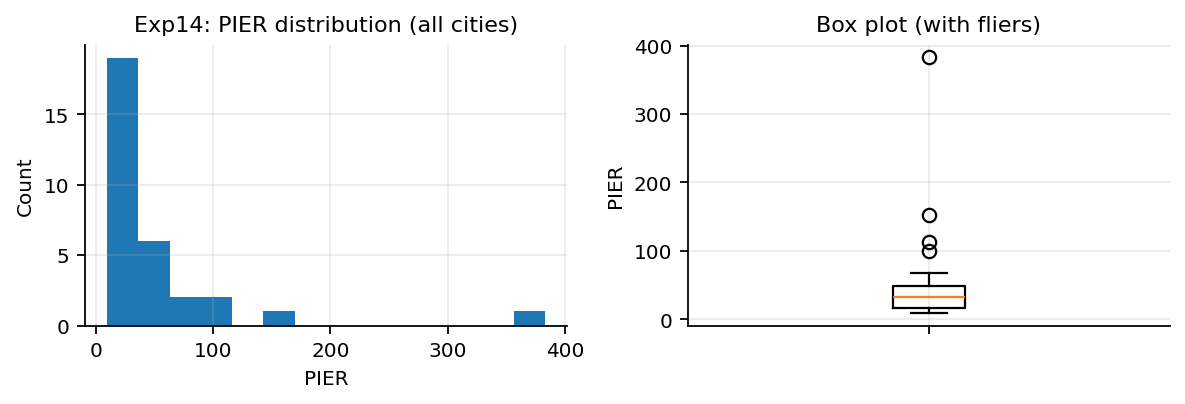

[Saved] ..\results\figs\exp14_pier_distribution_no_iqr.png


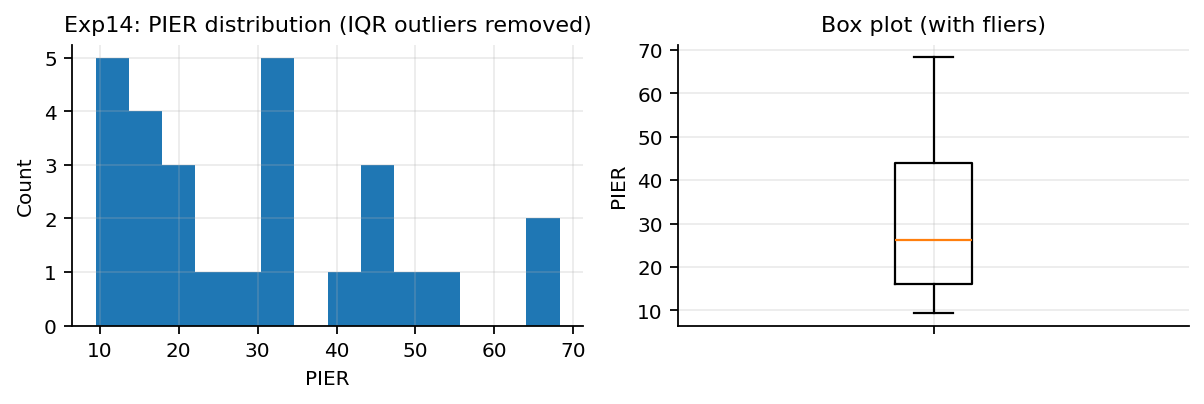

In [5]:

# -----------------------------
# Plot 1: PIER distribution + highlight outliers
# -----------------------------
def plot_pier_distribution(df_in: pd.DataFrame, title: str, save_name: str = None):
    x = df_in["PIER"].to_numpy(dtype=float)
    x = x[np.isfinite(x)]

    fig = plt.figure(figsize=(7.6, 2.6))
    ax1 = plt.subplot(1, 2, 1)
    ax1.hist(x, bins=14)
    ax1.set_title(title)
    ax1.set_xlabel("PIER")
    ax1.set_ylabel("Count")

    ax2 = plt.subplot(1, 2, 2)
    ax2.boxplot(x, vert=True, showfliers=True)
    ax2.set_title("Box plot (with fliers)")
    ax2.set_ylabel("PIER")
    ax2.set_xticks([1])
    ax2.set_xticklabels([""])

    plt.tight_layout()

    if save_name is not None:
        out = os.path.join(FIG_DIR, save_name)
        plt.savefig(out, bbox_inches="tight")
        print("[Saved]", out)

    plt.show()

plot_pier_distribution(df0, "Exp14: PIER distribution (all cities)", save_name="exp14_pier_distribution_all.png")
plot_pier_distribution(df_no_iqr, "Exp14: PIER distribution (IQR outliers removed)", save_name="exp14_pier_distribution_no_iqr.png")


[Saved] ..\results\figs\exp14_scatter_pier_vs_delta_router.png


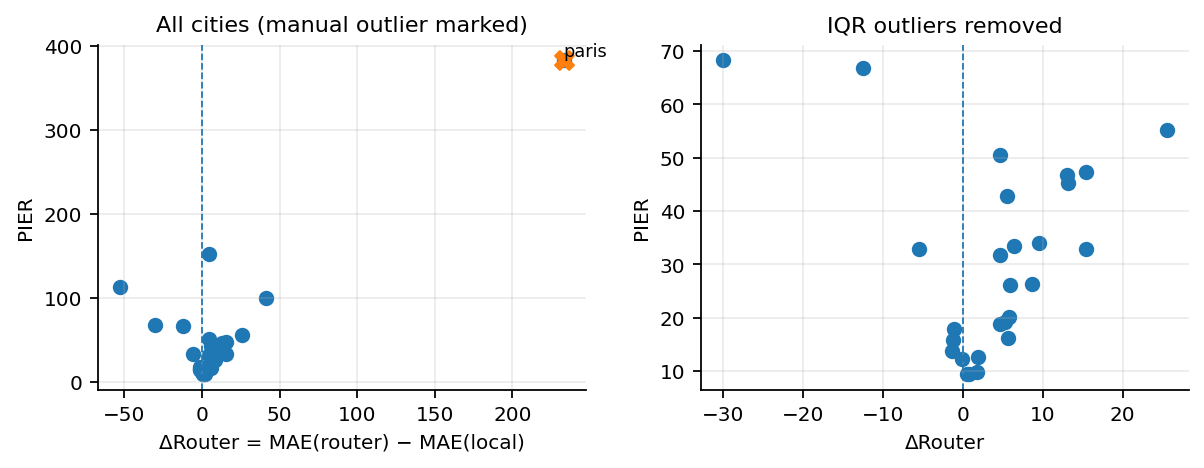

In [6]:

# -----------------------------
# Plot 2: Scatter PIER vs ΔRouter (with outliers marked)
# -----------------------------
def scatter_pier_vs_delta(df_all: pd.DataFrame, df_clean: pd.DataFrame, label_clean: str, save_name: str = None):
    fig = plt.figure(figsize=(7.6, 3.0))

    ax1 = plt.subplot(1, 2, 1)
    ax1.scatter(df_all["Delta_Router"], df_all["PIER"], s=35)
    for _, r in df_all[df_all["City"].isin(MANUAL_EXCLUDE)].iterrows():
        ax1.scatter([r["Delta_Router"]], [r["PIER"]], s=70, marker="X")
        ax1.text(r["Delta_Router"], r["PIER"], str(r["City"]), fontsize=8, ha="left", va="bottom")
    ax1.axvline(0.0, linewidth=0.8, linestyle="--")
    ax1.set_xlabel("ΔRouter = MAE(router) − MAE(local)")
    ax1.set_ylabel("PIER")
    ax1.set_title("All cities (manual outlier marked)")

    ax2 = plt.subplot(1, 2, 2)
    ax2.scatter(df_clean["Delta_Router"], df_clean["PIER"], s=35)
    ax2.axvline(0.0, linewidth=0.8, linestyle="--")
    ax2.set_xlabel("ΔRouter")
    ax2.set_ylabel("PIER")
    ax2.set_title(label_clean)

    plt.tight_layout()
    if save_name is not None:
        out = os.path.join(FIG_DIR, save_name)
        plt.savefig(out, bbox_inches="tight")
        print("[Saved]", out)
    plt.show()

scatter_pier_vs_delta(df0, df_no_iqr, "IQR outliers removed", save_name="exp14_scatter_pier_vs_delta_router.png")


[Saved] ..\results\figs\exp14_quadrant_all.png


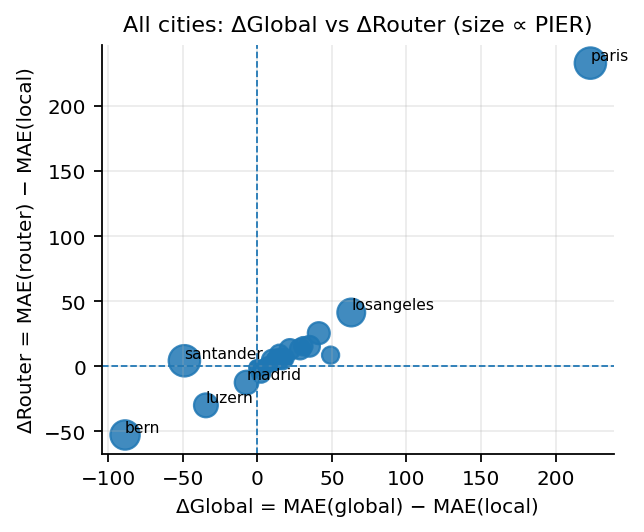

[Saved] ..\results\figs\exp14_quadrant_no_iqr.png


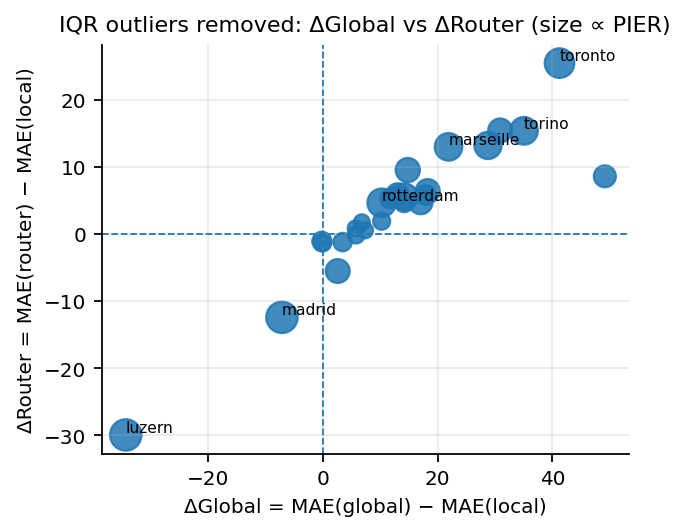

In [7]:

# -----------------------------
# Plot 3: Quadrant plot (ΔGlobal vs ΔRouter) with point size ~ PIER
# -----------------------------
def quadrant_plot(df_in: pd.DataFrame, title: str, save_name: str = None):
    dfp = df_in.copy()
    # Size scaling (robust): clip at 95th percentile to avoid one point dominating
    s_raw = dfp["PIER"].to_numpy(dtype=float)
    s_clip = np.nanpercentile(s_raw, 95)
    s = np.clip(s_raw, 0.0, s_clip)
    s = 25.0 + 175.0 * (s / (s_clip + 1e-12))

    fig = plt.figure(figsize=(4.1, 3.4))
    ax = plt.gca()
    ax.scatter(dfp["Delta_Global"], dfp["Delta_Router"], s=s, alpha=0.85)

    ax.axhline(0.0, linewidth=0.8, linestyle="--")
    ax.axvline(0.0, linewidth=0.8, linestyle="--")

    ax.set_xlabel("ΔGlobal = MAE(global) − MAE(local)")
    ax.set_ylabel("ΔRouter = MAE(router) − MAE(local)")
    ax.set_title(title)

    # Annotate a few extremes (largest PIER after filtering)
    top = dfp.sort_values("PIER", ascending=False).head(6)
    for _, r in top.iterrows():
        ax.text(r["Delta_Global"], r["Delta_Router"], str(r["City"]), fontsize=7, ha="left", va="bottom")

    plt.tight_layout()
    if save_name is not None:
        out = os.path.join(FIG_DIR, save_name)
        plt.savefig(out, bbox_inches="tight")
        print("[Saved]", out)
    plt.show()

quadrant_plot(df0, "All cities: ΔGlobal vs ΔRouter (size ∝ PIER)", save_name="exp14_quadrant_all.png")
quadrant_plot(df_no_iqr, "IQR outliers removed: ΔGlobal vs ΔRouter (size ∝ PIER)", save_name="exp14_quadrant_no_iqr.png")


[Saved] ..\results\figs\exp14_pier_vs_fitdistance.png


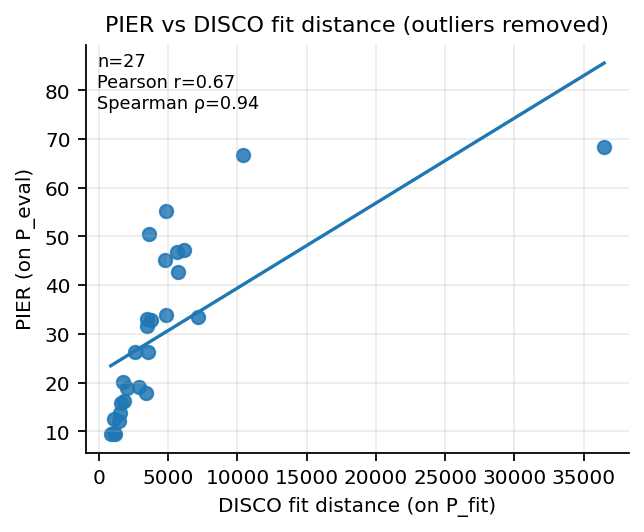

[Saved] ..\results\figs\exp14_pier_vs_pairwise_mean_abs_diff.png


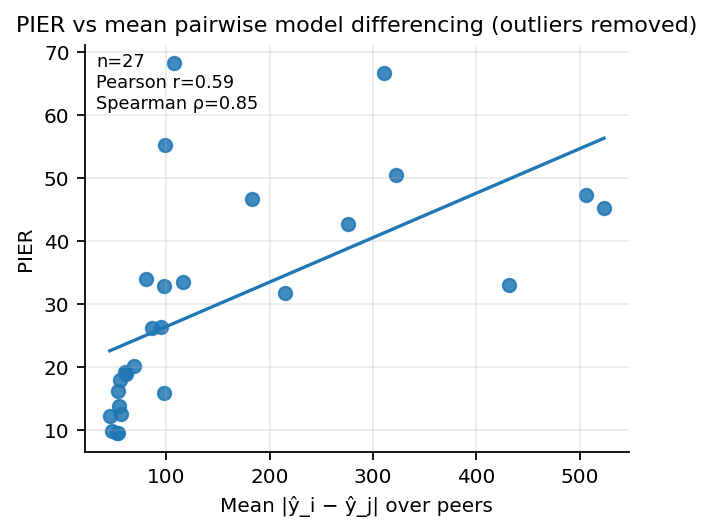

[Saved] ..\results\figs\exp14_pier_vs_entropy_norm.png


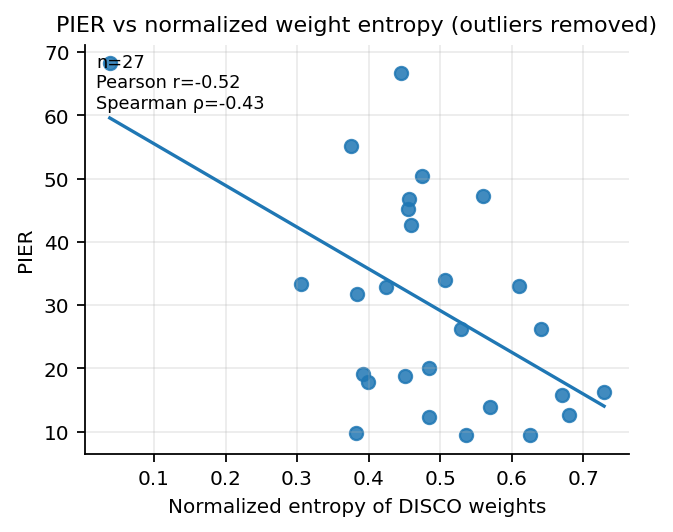

[Saved] ..\results\figs\exp14_pier_vs_effective_peers.png


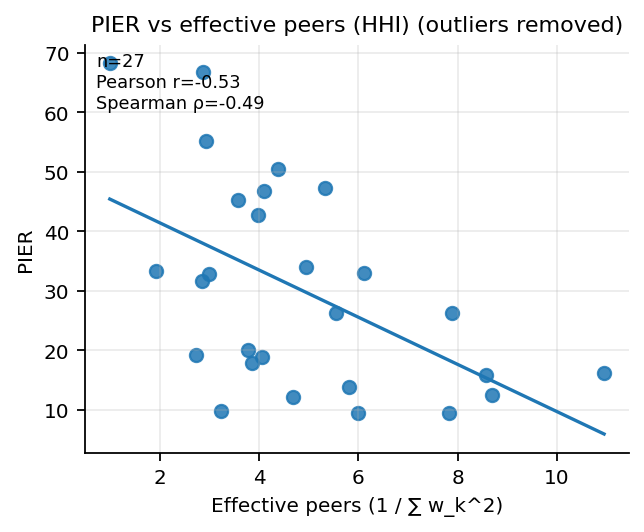

In [8]:

# -----------------------------
# Evidence chain checks (after outlier removal):
# 1) PIER aligns with internal "approximation hardness" (FitDistance, PairwiseMeanAbsDiff)
# 2) PIER relates to how concentrated the convex fit is (entropy / effective peers)
# -----------------------------
def scatter_with_fit(df_in: pd.DataFrame, xcol: str, ycol: str, title: str, xlabel: str, ylabel: str, save_name: str = None):
    x = df_in[xcol].to_numpy(dtype=float)
    y = df_in[ycol].to_numpy(dtype=float)
    mask = np.isfinite(x) & np.isfinite(y)
    x = x[mask]
    y = y[mask]

    fig = plt.figure(figsize=(4.1, 3.4))
    ax = plt.gca()
    ax.scatter(x, y, s=35, alpha=0.85)

    # Linear fit (least squares) for visualization only
    if x.size >= 3:
        a, b = np.polyfit(x, y, deg=1)
        xx = np.linspace(np.min(x), np.max(x), 100)
        yy = a * xx + b
        ax.plot(xx, yy, linewidth=1.5)

    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)

    # Correlation report (robust: Pearson + Spearman)
    stats = corr_pair(x, y)
    ax.text(
        0.02, 0.98,
        f"n={stats['n']}\nPearson r={stats['pearson']:.2f}\nSpearman ρ={stats['spearman']:.2f}",
        transform=ax.transAxes,
        ha="left", va="top", fontsize=8
    )

    plt.tight_layout()
    if save_name is not None:
        out = os.path.join(FIG_DIR, save_name)
        plt.savefig(out, bbox_inches="tight")
        print("[Saved]", out)
    plt.show()

df_clean = df_no_iqr.copy()

if "FitDistance" in df_clean.columns:
    scatter_with_fit(
        df_clean, "FitDistance", "PIER",
        title="PIER vs DISCO fit distance (outliers removed)",
        xlabel="DISCO fit distance (on P_fit)",
        ylabel="PIER (on P_eval)",
        save_name="exp14_pier_vs_fitdistance.png",
    )

if "PairwiseMeanAbsDiff" in df_clean.columns:
    scatter_with_fit(
        df_clean, "PairwiseMeanAbsDiff", "PIER",
        title="PIER vs mean pairwise model differencing (outliers removed)",
        xlabel="Mean |ŷ_i − ŷ_j| over peers",
        ylabel="PIER",
        save_name="exp14_pier_vs_pairwise_mean_abs_diff.png",
    )

if "WeightEntropyNorm" in df_clean.columns:
    scatter_with_fit(
        df_clean, "WeightEntropyNorm", "PIER",
        title="PIER vs normalized weight entropy (outliers removed)",
        xlabel="Normalized entropy of DISCO weights",
        ylabel="PIER",
        save_name="exp14_pier_vs_entropy_norm.png",
    )

if "EffectivePeers_HHI" in df_clean.columns:
    scatter_with_fit(
        df_clean, "EffectivePeers_HHI", "PIER",
        title="PIER vs effective peers (HHI) (outliers removed)",
        xlabel="Effective peers (1 / ∑ w_k^2)",
        ylabel="PIER",
        save_name="exp14_pier_vs_effective_peers.png",
    )


In [9]:

# -----------------------------
# Summary tables for writing the paper (after outlier removal)
# -----------------------------
df_clean = df_no_iqr.copy()

# Define a few interpretable "types" (paper-friendly):
# - Healthy unique:     ΔGlobal>0 and ΔRouter>0 and high PIER
# - Healthy redundant:  ΔGlobal>0 and ΔRouter>0 and low PIER
# - Unhealthy unique:   (ΔGlobal<0 or ΔRouter<0) and high PIER
# - Unhealthy redundant:(ΔGlobal<0 or ΔRouter<0) and low PIER
#
# Thresholds are robust quantiles (not arbitrary constants).
pier_hi = float(df_clean["PIER"].quantile(0.75))
pier_lo = float(df_clean["PIER"].quantile(0.25))

df_clean["Type"] = "Other"
df_clean.loc[df_clean["Healthy"] & (df_clean["PIER"] >= pier_hi), "Type"] = "Healthy-Unique"
df_clean.loc[df_clean["Healthy"] & (df_clean["PIER"] <= pier_lo), "Type"] = "Healthy-Redundant"
df_clean.loc[df_clean["Unhealthy"] & (df_clean["PIER"] >= pier_hi), "Type"] = "Unhealthy-Unique"
df_clean.loc[df_clean["Unhealthy"] & (df_clean["PIER"] <= pier_lo), "Type"] = "Unhealthy-Redundant"

print("PIER quantiles (clean): Q25=%.3f, Q75=%.3f" % (pier_lo, pier_hi))
print("\nCounts by Type:")
display(df_clean["Type"].value_counts().to_frame("count"))

cols_show = [
    "City", "Type", "PIER",
    "Local_MAE", "Global_MAE", "Router_MAE",
    "Delta_Global", "Delta_Router",
    "Local_MAE_Ratio", "Skill_vs_Persist",
    "ClosestPeerName", "ClosestPeerMeanAbsDiff",
    "WeightEntropyNorm", "EffectivePeers_HHI",
]

cols_show = [c for c in cols_show if c in df_clean.columns]

print("\nTop-10 PIER cities (clean):")
display(df_clean.sort_values("PIER", ascending=False)[cols_show].head(10))

print("\nBottom-10 PIER cities (clean):")
display(df_clean.sort_values("PIER", ascending=True)[cols_show].head(10))

print("\nHealthy-Unique examples:")
display(df_clean[df_clean["Type"] == "Healthy-Unique"].sort_values("PIER", ascending=False)[cols_show].head(8))

print("\nUnhealthy-Unique examples:")
display(df_clean[df_clean["Type"] == "Unhealthy-Unique"].sort_values("PIER", ascending=False)[cols_show].head(8))


PIER quantiles (clean): Q25=16.015, Q75=43.975

Counts by Type:


,count
Type,
Other,13
Healthy-Unique,5
Healthy-Redundant,4
Unhealthy-Redundant,3
Unhealthy-Unique,2



Top-10 PIER cities (clean):


,City,Type,PIER,Local_MAE,Global_MAE,Router_MAE,Delta_Global,Delta_Router,Local_MAE_Ratio,Skill_vs_Persist,ClosestPeerName,ClosestPeerMeanAbsDiff,WeightEntropyNorm,EffectivePeers_HHI
15,luzern,Unhealthy-Unique,68.263874,153.722327,119.292476,123.762925,-34.429852,-29.959402,0.525481,0.030337,taipeh,71.169494,0.038202,0.998791
16,madrid,Unhealthy-Unique,66.724794,140.528258,133.341620,128.114498,-7.186637,-12.413760,0.283951,0.017000,taipeh,77.375544,0.445489,2.882459
27,toronto,Healthy-Unique,55.189678,79.269703,120.512003,104.783757,41.242300,25.514054,0.296637,0.406293,essen,58.901172,0.375402,2.929825
20,rotterdam,Healthy-Unique,50.450626,69.751832,79.962402,74.434316,10.210570,4.682484,0.284237,0.223022,darmstadt,50.637449,0.475111,4.378858
26,torino,Healthy-Unique,47.212810,80.722430,115.760337,96.135401,35.037907,15.412971,0.204417,0.350332,manchester,64.598982,0.559420,5.333273
18,marseille,Healthy-Unique,46.726544,97.937908,119.813236,110.960531,21.875327,13.022623,0.244052,0.216522,strasbourg,47.196646,0.456464,4.099216
17,manchester,Healthy-Unique,45.211522,76.714563,105.472073,89.949673,28.757510,13.235110,0.185641,0.291325,bolton,55.416824,0.454885,3.586010
25,taipeh,Other,42.738627,140.143762,154.331825,145.739478,14.188063,5.595716,0.259895,0.168725,strasbourg,58.818738,0.458865,3.985566
12,kassel,Other,33.933109,90.243461,105.010658,99.808205,14.767197,9.564744,0.317508,0.245483,augsburg,30.006048,0.506421,4.941034
6,cagliari,Other,33.395506,86.589403,104.831241,93.007335,18.241839,6.417932,0.305377,0.182134,marseille,36.158798,0.305621,1.924988



Bottom-10 PIER cities (clean):


,City,Type,PIER,Local_MAE,Global_MAE,Router_MAE,Delta_Global,Delta_Router,Local_MAE_Ratio,Skill_vs_Persist,ClosestPeerName,ClosestPeerMeanAbsDiff,WeightEntropyNorm,EffectivePeers_HHI
11,hamburg,Healthy-Redundant,9.453996,49.206639,56.512941,49.759817,7.306302,0.553178,0.335525,0.191602,bremen,12.684031,0.536731,5.996075
5,bremen,Healthy-Redundant,9.514916,54.233149,59.907018,55.093581,5.673869,0.860432,0.296685,0.201207,hamburg,11.794414,0.626169,7.815991
22,speyer,Healthy-Redundant,9.746885,43.624621,50.382557,45.385684,6.757936,1.761063,0.310350,0.225048,bremen,10.243108,0.381862,3.235449
7,constance,Unhealthy-Redundant,12.222098,37.433328,43.176573,37.313408,5.743245,-0.119920,0.330728,0.144582,stuttgart,13.305445,0.484915,4.680817
10,graz,Healthy-Redundant,12.540365,44.782232,54.991841,46.716330,10.209609,1.934098,0.209234,0.305447,augsburg,14.747137,0.680172,8.683725
30,zurich,Unhealthy-Redundant,13.800258,60.490890,60.354633,59.203141,-0.136257,-1.287749,0.306806,0.109237,bremen,19.614172,0.569988,5.813812
23,strasbourg,Unhealthy-Redundant,15.829182,82.737752,86.133233,81.551721,3.395481,-1.186031,0.308443,0.163486,bremen,25.424253,0.670053,8.565384
0,augsburg,Other,16.201646,35.340211,47.803543,40.988873,12.463333,5.648662,0.220883,0.240336,london,16.231828,0.729331,10.946700
1,basel,Other,17.807652,70.371956,70.147956,69.314027,-0.224000,-1.057929,0.523288,0.090167,constance,20.774126,0.399453,3.869665
8,darmstadt,Other,18.814936,40.557695,54.693404,45.290473,14.135708,4.732777,0.309209,0.205883,hamburg,21.046337,0.450425,4.068185



Healthy-Unique examples:


,City,Type,PIER,Local_MAE,Global_MAE,Router_MAE,Delta_Global,Delta_Router,Local_MAE_Ratio,Skill_vs_Persist,ClosestPeerName,ClosestPeerMeanAbsDiff,WeightEntropyNorm,EffectivePeers_HHI
27,toronto,Healthy-Unique,55.189678,79.269703,120.512003,104.783757,41.242300,25.514054,0.296637,0.406293,essen,58.901172,0.375402,2.929825
20,rotterdam,Healthy-Unique,50.450626,69.751832,79.962402,74.434316,10.210570,4.682484,0.284237,0.223022,darmstadt,50.637449,0.475111,4.378858
26,torino,Healthy-Unique,47.212810,80.722430,115.760337,96.135401,35.037907,15.412971,0.204417,0.350332,manchester,64.598982,0.559420,5.333273
18,marseille,Healthy-Unique,46.726544,97.937908,119.813236,110.960531,21.875327,13.022623,0.244052,0.216522,strasbourg,47.196646,0.456464,4.099216
17,manchester,Healthy-Unique,45.211522,76.714563,105.472073,89.949673,28.757510,13.235110,0.185641,0.291325,bolton,55.416824,0.454885,3.586010



Unhealthy-Unique examples:


,City,Type,PIER,Local_MAE,Global_MAE,Router_MAE,Delta_Global,Delta_Router,Local_MAE_Ratio,Skill_vs_Persist,ClosestPeerName,ClosestPeerMeanAbsDiff,WeightEntropyNorm,EffectivePeers_HHI
15,luzern,Unhealthy-Unique,68.263874,153.722327,119.292476,123.762925,-34.429852,-29.959402,0.525481,0.030337,taipeh,71.169494,0.038202,0.998791
16,madrid,Unhealthy-Unique,66.724794,140.528258,133.341620,128.114498,-7.186637,-12.413760,0.283951,0.017000,taipeh,77.375544,0.445489,2.882459


In [10]:

# -----------------------------
# Sanity: show how conclusions change when removing *only* Paris vs robust outlier removal
# -----------------------------
def summary_stats(df_in: pd.DataFrame, label: str):
    stats = {
        "n": len(df_in),
        "PIER_mean": float(df_in["PIER"].mean()),
        "PIER_median": float(df_in["PIER"].median()),
        "PIER_p90": float(df_in["PIER"].quantile(0.90)),
        "DeltaRouter_mean": float(df_in["Delta_Router"].mean()),
        "DeltaGlobal_mean": float(df_in["Delta_Global"].mean()),
        "Healthy_frac": float(((df_in["Delta_Router"] >= 0) & (df_in["Delta_Global"] >= 0)).mean()),
    }
    print(f"\n[{label}]")
    for k, v in stats.items():
        if k == "n":
            print(f"  {k:>14s}: {int(v)}")
        else:
            print(f"  {k:>14s}: {v: .4f}")

summary_stats(df0, "All cities")
summary_stats(df_no_manual, "Manual exclude (paris) only")
summary_stats(df_no_iqr, "IQR outliers removed")

print_corr(df0, "PIER", "Delta_Router", "All: PIER vs ΔRouter")
print_corr(df_no_manual, "PIER", "Delta_Router", "No-paris: PIER vs ΔRouter")
print_corr(df_no_iqr, "PIER", "Delta_Router", "No-IQR-outliers: PIER vs ΔRouter")

print_corr(df0, "PIER", "Delta_Global", "All: PIER vs ΔGlobal")
print_corr(df_no_manual, "PIER", "Delta_Global", "No-paris: PIER vs ΔGlobal")
print_corr(df_no_iqr, "PIER", "Delta_Global", "No-IQR-outliers: PIER vs ΔGlobal")



[All cities]
               n: 31
       PIER_mean:  50.4500
     PIER_median:  32.8552
        PIER_p90:  99.9866
  DeltaRouter_mean:  10.6228
  DeltaGlobal_mean:  16.0988
    Healthy_frac:  0.7097

[Manual exclude (paris) only]
               n: 30
       PIER_mean:  39.3621
     PIER_median:  32.2841
        PIER_p90:  71.4361
  DeltaRouter_mean:  3.2097
  DeltaGlobal_mean:  9.1912
    Healthy_frac:  0.7000

[IQR outliers removed]
               n: 27
       PIER_mean:  30.1856
     PIER_median:  26.2587
        PIER_p90:  52.3462
  DeltaRouter_mean:  3.8262
  DeltaGlobal_mean:  12.9700
    Healthy_frac:  0.7407
[All: PIER vs ΔRouter] n=31 | Pearson r=0.803 (p=5.47e-08) | Spearman ρ=0.320 (p=7.91e-02)
[No-paris: PIER vs ΔRouter] n=30 | Pearson r=-0.147 (p=4.39e-01) | Spearman ρ=0.250 (p=1.83e-01)
[No-IQR-outliers: PIER vs ΔRouter] n=27 | Pearson r=-0.083 (p=6.81e-01) | Spearman ρ=0.347 (p=7.64e-02)
[All: PIER vs ΔGlobal] n=31 | Pearson r=0.600 (p=3.58e-04) | Spearman ρ=0.226 (p=2.2

[Saved] ..\results\figs\exp14_quadrant_pier_vs_delta_router_all.png


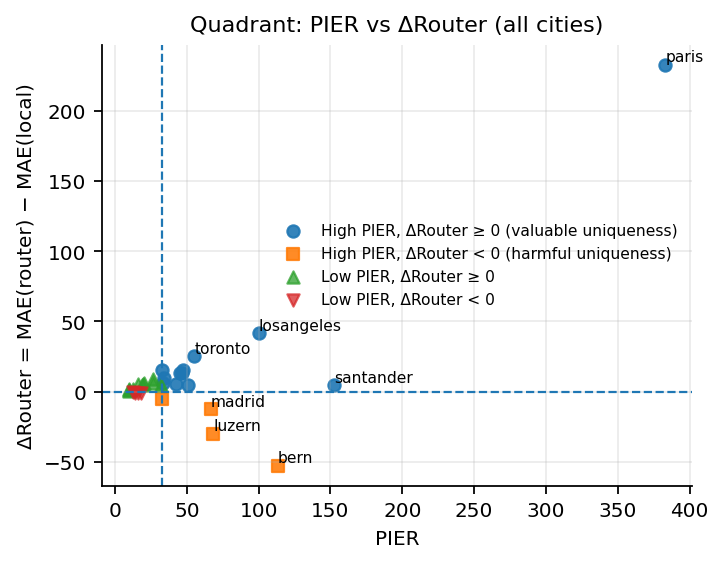

[Saved] ..\results\figs\exp14_quadrant_pier_vs_delta_router_no_iqr.png


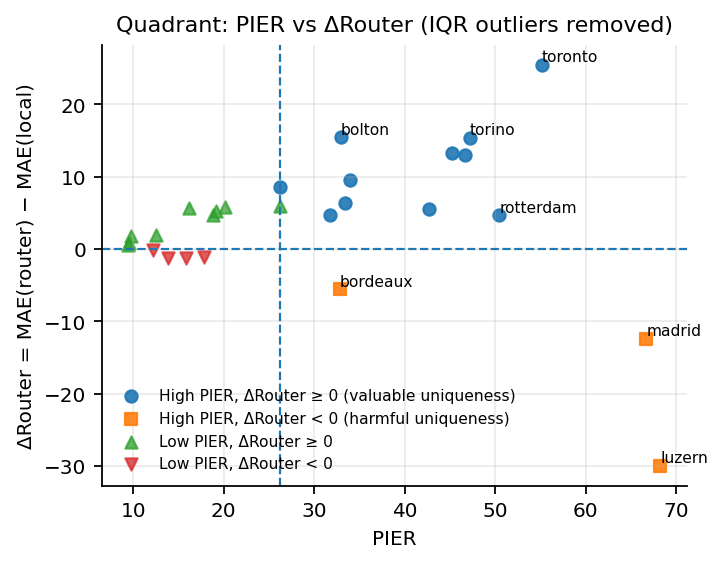

In [13]:
# -----------------------------
# Quadrant plot: PIER vs ΔRouter
# -----------------------------
def plot_quadrant_pier_delta_router(df_in: pd.DataFrame, title: str, pier_thr: float = None, save_name: str = None):
    """
    Quadrant view in (PIER, ΔRouter):
      - x-axis: PIER
      - y-axis: ΔRouter
    Thresholds:
      - vertical line: PIER median (or provided pier_thr)
      - horizontal line: ΔRouter = 0
    """
    d = df_in.copy()

    if pier_thr is None:
        pier_thr = float(d["PIER"].median())

    fig = plt.figure(figsize=(4.6, 3.6))
    ax = plt.gca()

    q1 = d[(d["PIER"] >= pier_thr) & (d["Delta_Router"] >= 0.0)]
    q2 = d[(d["PIER"] <  pier_thr) & (d["Delta_Router"] >= 0.0)]
    q3 = d[(d["PIER"] >= pier_thr) & (d["Delta_Router"] <  0.0)]
    q4 = d[(d["PIER"] <  pier_thr) & (d["Delta_Router"] <  0.0)]

    # Use different markers only (avoid custom colors)
    ax.scatter(q1["PIER"], q1["Delta_Router"], s=30, alpha=0.9, label="High PIER, ΔRouter ≥ 0 (valuable uniqueness)")
    ax.scatter(q3["PIER"], q3["Delta_Router"], s=30, alpha=0.9, marker="s", label="High PIER, ΔRouter < 0 (harmful uniqueness)")
    ax.scatter(q2["PIER"], q2["Delta_Router"], s=30, alpha=0.75, marker="^", label="Low PIER, ΔRouter ≥ 0")
    ax.scatter(q4["PIER"], q4["Delta_Router"], s=30, alpha=0.75, marker="v", label="Low PIER, ΔRouter < 0")

    ax.axvline(pier_thr, linewidth=1.0, linestyle="--")
    ax.axhline(0.0, linewidth=1.0, linestyle="--")

    ax.set_xlabel("PIER")
    ax.set_ylabel("ΔRouter = MAE(router) − MAE(local)")
    ax.set_title(title)

    # Annotate a few informative cities
    to_anno = []
    to_anno += d.sort_values("PIER", ascending=False)["City"].head(4).tolist()
    to_anno += d.sort_values("Delta_Router", ascending=False)["City"].head(3).tolist()
    to_anno += d.sort_values("Delta_Router", ascending=True)["City"].head(3).tolist()
    to_anno = list(dict.fromkeys(to_anno))

    for city in to_anno:
        sub = d[d["City"] == city]
        if sub.empty:
            continue
        x = float(sub.iloc[0]["PIER"])
        y = float(sub.iloc[0]["Delta_Router"])
        ax.text(x, y, city, fontsize=7, ha="left", va="bottom")

    ax.legend(loc="best", fontsize=7)
    plt.tight_layout()

    if save_name is not None:
        out = os.path.join(FIG_DIR, save_name)
        plt.savefig(out, bbox_inches="tight")
        print("[Saved]", out)

    plt.show()


# All cities
plot_quadrant_pier_delta_router(
    df0,
    title="Quadrant: PIER vs ΔRouter (all cities)",
    pier_thr=float(df0["PIER"].median()),
    # pier_thr=float(df["PIER"].quantile(0.75)),
    save_name="exp14_quadrant_pier_vs_delta_router_all.png",
)

# IQR outliers removed (PIER-based)
plot_quadrant_pier_delta_router(
    df_no_iqr,
    title="Quadrant: PIER vs ΔRouter (IQR outliers removed)",
    pier_thr=float(df_no_iqr["PIER"].median()),
    # pier_thr=float(df["PIER"].quantile(0.75)),
    save_name="exp14_quadrant_pier_vs_delta_router_no_iqr.png",
)
